# Python Write

## Import

In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
from pandas.io import sql
import gvar
import csv

## Tests

### SQL

In [2]:
def test_sql_write(df, FILE):
    if os.path.exists(FILE):
        os.remove(FILE)
    sql_db = sqlite3.connect(FILE)
    df.to_sql(name='test_table', con=sql_db, index=False)
    sql_db.close()

def test_sql_read(FILE):
    sql_db = sqlite3.connect(FILE)
    sql.read_sql("select * from test_table", sql_db )
    sql_db.close()

### Pandas

In [3]:
def test_hdf_fixed_write(df, FILE):
    df.to_hdf(FILE, 'test', mode='w')

def test_hdf_fixed_read(FILE):
    pd.read_hdf(FILE,'test')
    
def test_csv_write(df, FILE):
    df.to_csv(FILE, mode='w', index=False)

def test_csv_read(FILE):
    pd.read_csv(FILE, index_col=None)

def test_hdf_table_write(df, FILE):
    df.to_hdf(FILE,'test',format='table',mode='w')

def test_hdf_table_read(FILE):
    pd.read_hdf(FILE, 'test')

### Array Write

In [4]:
def numpy_csv_write(arr, FILE):
    np.savetxt(FILE, arr, delimiter=",")

def numpy_csv_read(FILE):
    np.loadtxt(FILE, delimiter=",")

### Methods

In [5]:
write_dict = {
    "pandas-fixed": test_hdf_fixed_write,
    "pandas-table": test_hdf_table_write,
    "pandas-csv"  : test_csv_write,
    "sqlite"      : test_sql_write,
    "numpy"       : numpy_csv_write,
}
read_dict = {
    "pandas-fixed": test_hdf_fixed_read,
    "pandas-table": test_hdf_table_read,
    "pandas-csv"  : test_csv_read,
    "sqlite"      : test_sql_read,
    "numpy"       : numpy_csv_read,
}
extension = {
    "pandas-fixed": "hdf",
    "pandas-table": "hdf",
    "pandas-csv"  : "csv",
    "sqlite"      : "sql",
    "numpy"       : "csv",
}

## Run Benchmark

In [6]:
CWD  = os.getcwd()
BASE = os.path.join(CWD,"files")
if not os.path.exists(BASE):
     os.mkdir(BASE)

In [8]:
data = []

for Nexp in [4,5,6]:
    NArr = 10**Nexp
    arr = np.random.randn(NArr,2)
    df  = pd.DataFrame(arr, columns=["A", "B"])

    for method, write in write_dict.items():
        FILE  = os.path.join(BASE, method+"."+extension[method])
        if method in ["numpy", "io"]:
            inp = arr
        else:
            inp = df
        wTime = %timeit -o write(inp, FILE)
        rTime = %timeit -o read_dict[method](FILE)
        data += [{
            "NArr"  : NArr,
            "method": method,
            "wTime" : gvar.gvar(wTime.average, wTime.stdev),
            "rTime" : gvar.gvar(rTime.average, rTime.stdev),
            "fSize" : os.stat(FILE).st_size,
        }]

DF = pd.DataFrame(data)
DF.head()

6.62 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.64 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.33 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
41 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.38 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.5 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 84.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
41.5 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
78.9 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.22 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.05 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.2 ms ± 881 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.95 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
393 ms ± 

,NArr,fSize,method,rTime,wTime
0,10000,247192,pandas-fixed,0.00564(28),0.00662(24)
1,10000,284554,pandas-table,0.00733(25),0.01297(31)
2,10000,392805,pandas-csv,0.00738(13),0.0410(11)
3,10000,249856,sqlite,0.010385(84),0.0185(38)
4,10000,510085,numpy,0.0789(25),0.0415(11)


## Plotting

In [59]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set(font_scale=0.6, style="ticks")

In [65]:
def split_row(row):
    row["rTime_mean"] = row["rTime"].mean
    row["wTime_mean"] = row["wTime"].mean
    row["fSize_mean"] = row["fSize"]
    row["rTime_std" ] = row["rTime"].sdev
    row["wTime_std" ] = row["wTime"].sdev
    row["fSize_std" ] = 0
    return row
pf = DF.apply(split_row, axis=1)

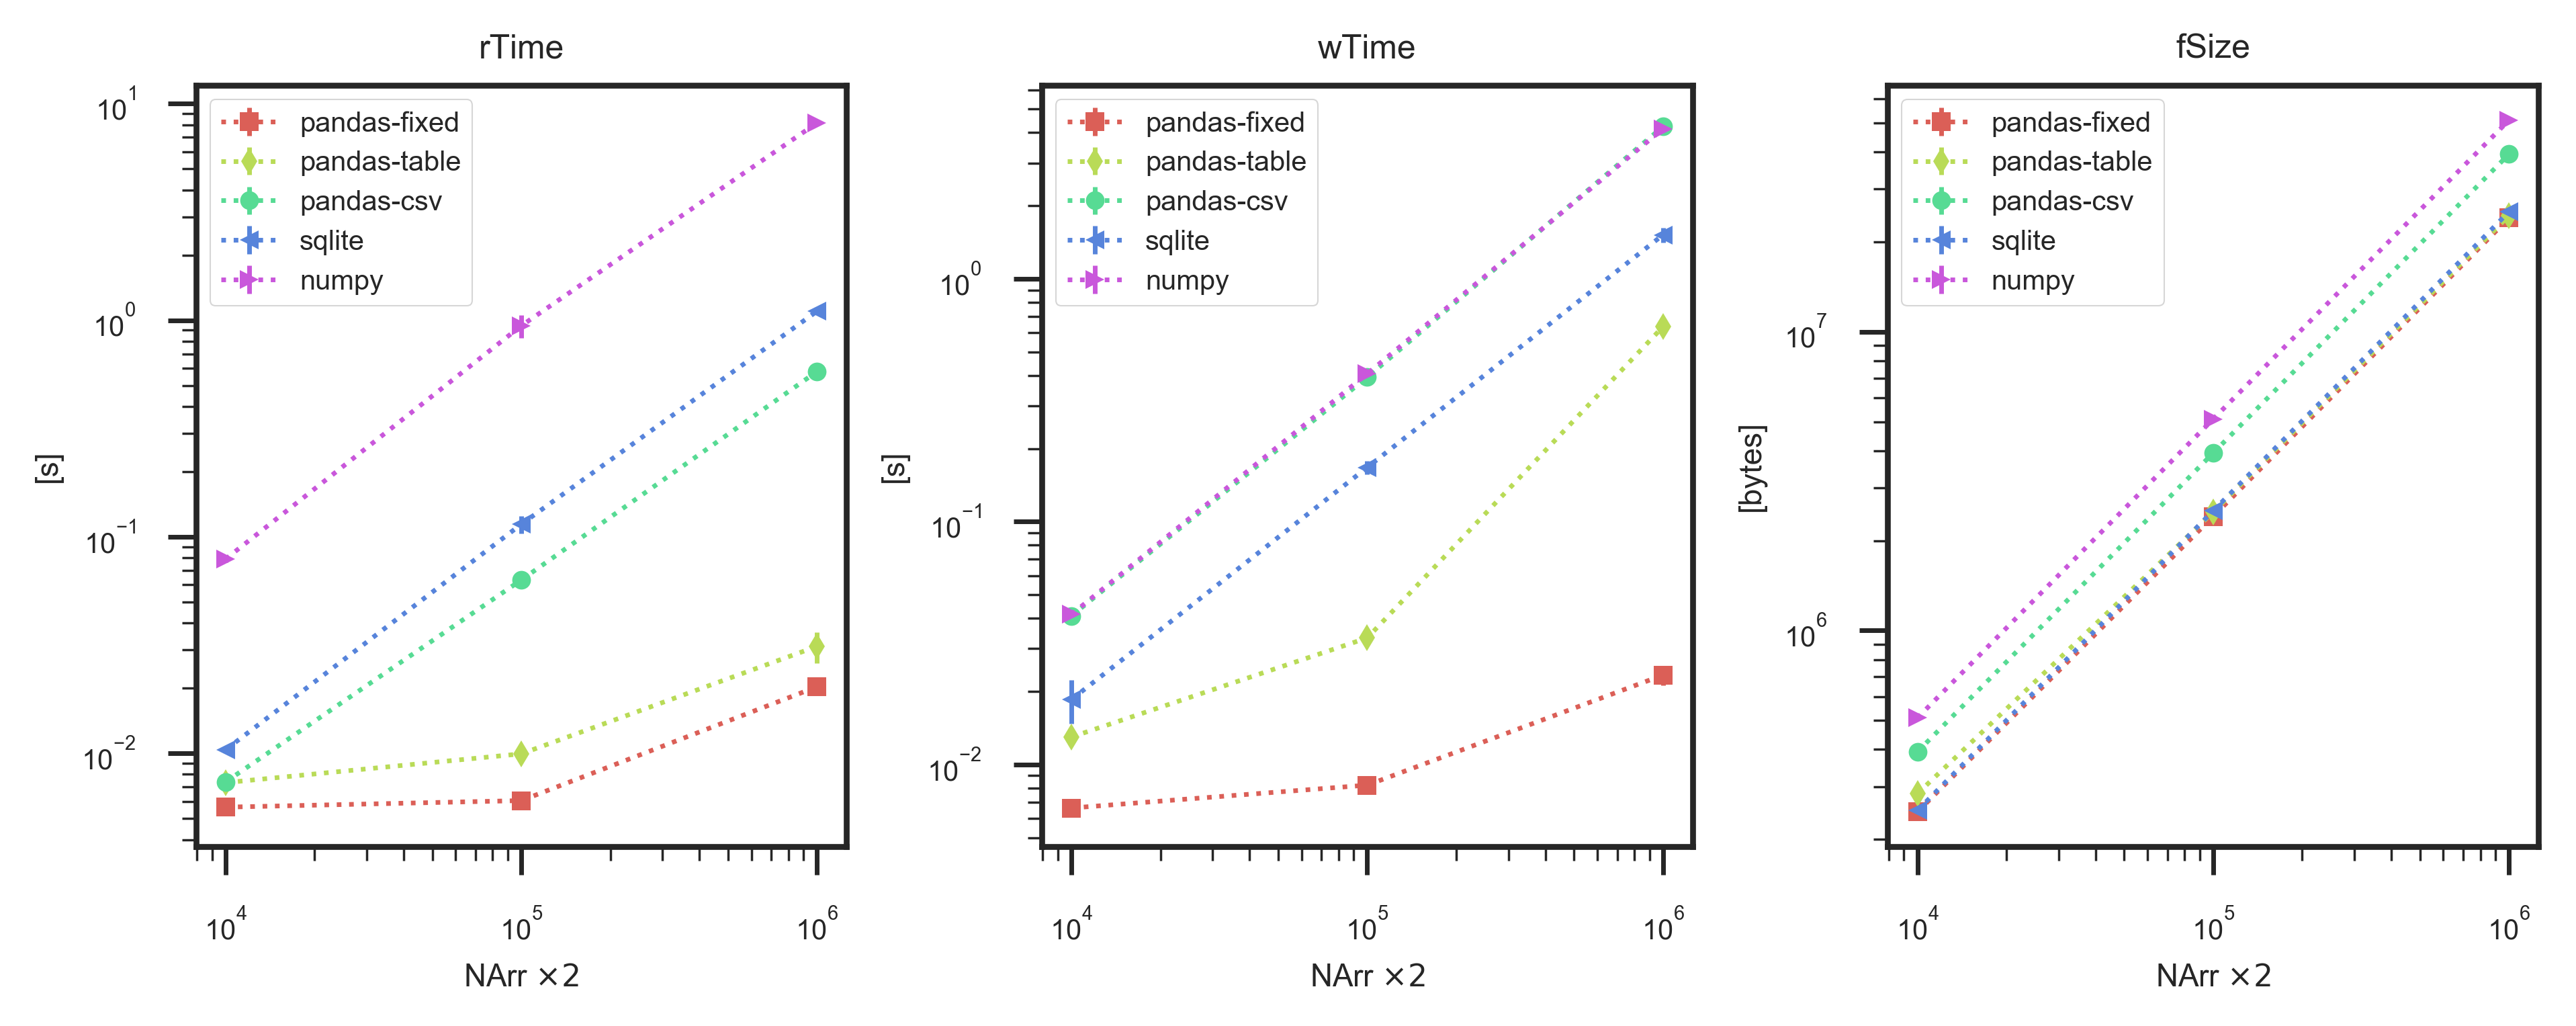

In [86]:
fig, axs = plt.subplots(figsize=(9,3), dpi=500, ncols=3, sharex=True)
ax = fig.gca()

methods = pf.method.unique()
cmap    = sns.color_palette("hls", len(methods))
pkwargs = {"linestyle":":", "ms":4, "lw":1}
ylabel  = {"rTime": "[s]", "wTime": "[s]", "fSize": "[bytes]",}
markers = ["s", "d", "o", "<", ">"]

for ax, label in zip(axs, ["rTime", "wTime", "fSize"]):
    for nm, method in enumerate(methods):
        tf = pf.query("method == @method")
        ax.errorbar(tf["NArr"], tf[label+"_mean"], tf[label+"_std"], label=method, color=cmap[nm], marker=markers[nm], **pkwargs)
    ax.set_title(label)
    ax.set_ylabel(ylabel[label])
    ax.set_yscale("log")
    ax.legend(loc="upper left", frameon=True)
    ax.set_xlabel(r"NArr $\times 2$")

ax.set_xscale("log")


plt.subplots_adjust(wspace=0.3)
plt.show(fig)

In [87]:
fig.savefig("PythonIOBench.pdf", bbox_inches="tight")

In [88]:
!open PythonIOBench.pdf